## Label conditioned autoregressive model 

> we will use LLamagen codebase for this 

> we will use vqgan tranied in the first step to encode and decode the image. the vqgan has perplexity score of around ~1500/2048 and is trained on MNIST. 

> It also uses classifier free guidance which actually complicates inference but training comes for free of cost.

LLamagen uses transformer from LLama which uses the following things 
- Rotary RoPE encodings 
- Pre-normalization 
- SwiGLU activation


In [1]:
import torch
import torchvision
from tqdm import tqdm
from gpt import Transformer, ModelArgs as ArModelArgs
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline


In [2]:
MEAN = (0.1307,)
STD = (0.3081,)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(mean=MEAN, std=STD)  # MNIST standard normalization
                                ])),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(mean=MEAN, std=STD)  # MNIST standard normalization
                                ])),
    batch_size=128, shuffle=False)

len(train_loader), len(val_loader)

(469, 79)

In [3]:
imgs, labels = next(iter(val_loader))
imgs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

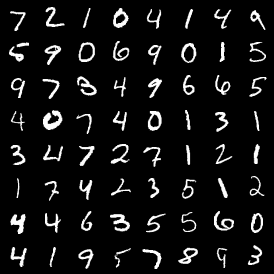

In [4]:
pimg = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((imgs[:64]*STD[0])+MEAN[0], nrow=8))
pimg

> lets load these images into encoder of vqgan and then load back again with vqgan decoder.

In [5]:
## VQGAN model 
from vqgan import VQModel, ModelArgs
cfg = ModelArgs(
    codebook_size=2048, 
    codebook_embed_dim=8, 
    codebook_l2_norm=True, 
    codebook_show_usage=True, 
    commit_loss_beta=0.25, 
    entropy_loss_ratio=0.0, 
    encoder_ch_mult=[1, 4, 4], 
    decoder_ch_mult=[1, 4, 4], 
    z_channels=256, 
    dropout_p=0.0, 
)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqgan = VQModel(cfg)
weights = torch.load('pretrained/exp3_ema_model_599_rl_0.045263_vl_0.058811_perp_1461.302002.pth')
vqgan.load_state_dict(weights["model"])
vqgan.eval()
vqgan.to(DEVICE)
print("Model loaded")


Model loaded


In [6]:
with torch.no_grad():
    imgs = imgs.to(DEVICE)
    quant, emb_loss, info = vqgan.encode(imgs)
quant.shape, emb_loss, info[2]

(torch.Size([128, 8, 8, 8]),
 (None, None, None, 0),
 tensor([ 621,  474,  998,  ..., 1899, 1261,  998], device='cuda:0'))

In [7]:
codebook_indices = info[2].reshape(128, -1)
codebook_indices.shape

torch.Size([128, 64])

In [8]:
with torch.no_grad():
    dec = vqgan.decode_code(info[2].reshape(128, -1), shape=(128, 8, 8, 8), channel_first=True)
print(dec.shape)

torch.Size([128, 1, 32, 32])


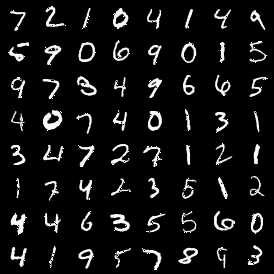

In [9]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((dec[:64, ...]*STD[0])+MEAN[0], nrow=8))

In [10]:
#calculate L1 loss
torch.nn.L1Loss()(dec, imgs)

tensor(0.0300, device='cuda:0')

In [11]:
ModelArgs()

ModelArgs(codebook_size=16384, codebook_embed_dim=8, codebook_l2_norm=True, codebook_show_usage=True, commit_loss_beta=0.25, entropy_loss_ratio=0.0, encoder_ch_mult=[1, 1, 2, 2, 4], decoder_ch_mult=[1, 1, 2, 2, 4], z_channels=256, dropout_p=0.0)

In [12]:
from gpt import ModelArgs as ArModelArgs
# key changes are ffn_dim_multiplier and multiple_of 
# layers, head and kv_head changes are normal 
ar_config = ArModelArgs(
    dim=256, # dimension of the embedding model, 
    n_layer=8, # number of layers in the transformer
    n_head=8, # number of attention heads in the transformer
    n_kv_head=8, # number of key-value heads in the transformer
    multiple_of=8*8, # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier=2, # multiplier for the feed-forward dimension
    rope_base=10000, # base for the rotary positional encodings

    num_classes=10, # number of classes in the dataset
    model_type='c2i', # model type
    vocab_size=2048, # vocabulary size
    cls_token_num=1, # number of cls tokens
    block_size=8*8, # block size
    max_batch_size=128, # maximum batch size
    max_seq_len=8*8, # maximum sequence length
)
ar_model = Transformer(ar_config)
ar_model.initialize_weights()
ar_model.setup_caches(max_batch_size=128, max_seq_length=8*8, dtype=torch.float32)
ar_model.to(DEVICE)
print(ar_model, ar_model.training)


Transformer(
  (cls_embedding): LabelEmbedder(
    (embedding_table): Embedding(11, 256)
  )
  (tok_embeddings): Embedding(2048, 256)
  (tok_dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): Attention(
        (wqkv): Linear(in_features=256, out_features=768, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (kv_cache): KVCache()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=256, out_features=1408, bias=False)
        (w3): Linear(in_features=256, out_features=1408, bias=False)
        (w2): Linear(in_features=1408, out_features=256, bias=False)
        (ffn_dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (drop_path): Identity()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=256, out_features=2048, bias=False)
) True


In [13]:
params = sum(p.numel() for p in ar_model.parameters())
print(f"Number of parameters: {params}")


Number of parameters: 11803648


# lets see how masks are setup now 

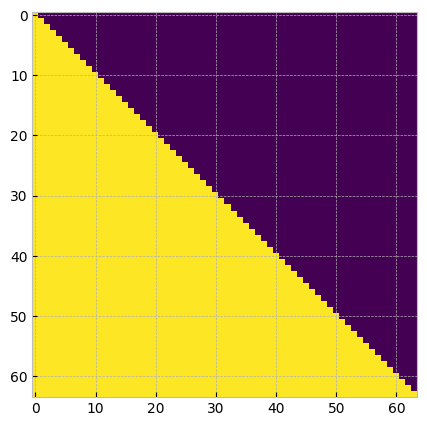

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(ar_model.causal_mask[0]) 
plt.show()

In [15]:
ar_model.causal_mask[0].shape

torch.Size([64, 64])

In [16]:
idx = info[2].reshape(128, -1)
cond_idx = labels.reshape(128,)
input_pos = torch.arange(64)
idx.shape, cond_idx.shape, input_pos.shape

(torch.Size([128, 64]), torch.Size([128]), torch.Size([64]))

In [17]:
ar_model.freqs_cis.shape

torch.Size([65, 16, 2])

In [18]:
logits, loss = ar_model(idx.cuda()[:,:-1], cond_idx=cond_idx.cuda(), input_pos=input_pos.cuda(), targets=idx.cuda())
logits.shape, loss

(torch.Size([128, 64, 2048]),
 tensor(7.6246, device='cuda:0', grad_fn=<NllLossBackward0>))

## inference code.
> basic inference: we have to generate all 64 codes given just the label. 

> use classifier guidance to generate all 64 codes given labels. 

> we will generate 128 images at a time 

In [19]:
from sample import generate
ar_model.eval()
print("model in eval mode")

model in eval mode


In [20]:
#prefill 
cfg_scale = 7.5
c_indices = torch.randint(0, 10, (128,)).cuda()
qzshape = [len(c_indices), 8, 8, 8]
c_indices.shape, qzshape

(torch.Size([128]), [128, 8, 8, 8])

#  Parameters and its significance
cfg_scale: is used to do a prediction with label and without label
```
logits = uncond_logits + (cond_logits - uncond_logits) * cfg_scale 
```

In [21]:
gen_seq = generate(ar_model, c_indices, 64, cfg_scale=cfg_scale, cfg_interval=-1, temperature=1.0, top_k=200, top_p=1.0, sample_logits=True, )
gen_seq.shape

/home/prakash/.local/share/uv/python/cpython-3.10.16-linux-x86_64-gnu/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


torch.Size([128, 64])

In [22]:
with torch.no_grad():
    dec = vqgan.decode_code(gen_seq, shape=(128, 8, 8, 8), channel_first=True)
print(dec.shape)

torch.Size([128, 1, 32, 32])


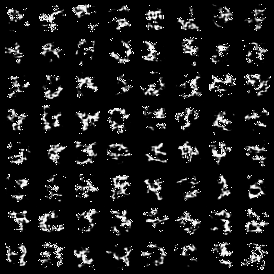

In [23]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((dec[:64, ...]*STD[0])+MEAN[0], nrow=8))

## calculate fid score

In [24]:
imgs.shape, dec.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128, 1, 32, 32]))

In [25]:
pimgs = (torch.clamp((imgs*STD[0]+MEAN[0]), 0, 1)*255.0).to(torch.uint8)
pdec = (torch.clamp((dec*STD[0]+MEAN[0]), 0, 1)*255.0).to(torch.uint8)
pimgs.shape, pdec.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128, 1, 32, 32]))

In [26]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=2048).cuda()

# Add your real images
for real_image in pimgs:
    fid.update(real_image.repeat(3, 1, 1)[None, ...], real=True)

# Add your generated images
for gen_image in pdec:
    fid.update(gen_image.repeat(3, 1, 1)[None, ...], real=False)

# Calculate FID
fid_score = fid.compute()

fid_score

tensor(183.6046, device='cuda:0')

> store all the data.

In [27]:
inputs, labels = torch.empty(0, 8*8).to(DEVICE).long(), torch.empty(0).to(DEVICE).long()
val_inputs, val_labels = torch.empty(0, 8*8).to(DEVICE).long(), torch.empty(0).to(DEVICE).long()
with tqdm(train_loader, total=len(train_loader), desc="Training", leave=False) as pbar:
    for i, (img, label) in enumerate(pbar):
        with torch.no_grad():
            quant, emb_loss, info = vqgan.encode(img.cuda())
        codebook_indices = info[2].reshape(quant.shape[0], -1).long()
        inputs = torch.cat((inputs, codebook_indices), dim=0)
        labels = torch.cat((labels, label.long().cuda()), dim=0)
        pbar.set_postfix(total_data_points=inputs.shape[0])

with tqdm(val_loader, total=len(val_loader), desc="Validation", leave=False) as pbar:
    for i, (img, label) in enumerate(pbar):
        with torch.no_grad():
            quant, emb_loss, info = vqgan.encode(img.cuda())
        codebook_indices = info[2].reshape(quant.shape[0], -1).long()
        val_inputs = torch.cat((val_inputs, codebook_indices), dim=0)
        val_labels = torch.cat((val_labels, label.long().cuda()), dim=0)
inputs.shape, labels.shape, val_inputs.shape, val_labels.shape

(torch.Size([60000, 64]),
 torch.Size([60000]),
 torch.Size([10000, 64]),
 torch.Size([10000]))

In [28]:
#optimizers 
import inspect
def creat_optimizer(model, weight_decay, learning_rate, betas):
    # start with all of the candidate parameters
    param_dict = {pn: p for pn, p in model.named_parameters()}
    # filter out those that do not require grad
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
    print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    extra_args = dict(fused=True) if fused_available else dict()
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
    print(f"using fused AdamW: {fused_available}")
    return optimizer

In [29]:
class CodebookDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

ds = CodebookDataset(inputs, labels)
dl = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, drop_last=True)
dlv = torch.utils.data.DataLoader(CodebookDataset(val_inputs, val_labels), batch_size=128, shuffle=False, drop_last=True)
len(dl), len(dlv)


(468, 78)

In [30]:
## EMA 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta, beta_correction=True):
        super().__init__()
        self.beta = beta
        self.beta_correction = beta_correction
        self.step = 0
    def update_average(self, old, new):
        if not exists(old):
            return new
        if self.beta_correction:
            self.step+=1
            beta_correction = 1-self.beta**self.step
        else:
            beta_correction=1
        return old * self.beta + (1 - self.beta) * new/beta_correction

ema = EMA(beta=1)
#ema_vqgan = copy.deepcopy(vqgan)
ar_model = Transformer(ar_config)
ar_model.to(DEVICE)
ar_model.initialize_weights()
ar_model.setup_caches(max_batch_size=128, max_seq_length=8*8, dtype=torch.float32)

print("Loaded AR model")
ema_ar_model = Transformer(ar_config)
ema_ar_model.to(DEVICE)
ema_ar_model.initialize_weights()
ema_ar_model.setup_caches(max_batch_size=128, max_seq_length=8*8, dtype=torch.float32)
ema_ar_model.load_state_dict(ar_model.state_dict())
print("Loaded EMA model")
#ema_vqgan = type(vqgan)(*vqgan.__init_args__, **vqgan.__init_kwargs__)
#ema_vqgan.load_state_dict(vqgan.state_dict().copy())

Loaded AR model
Loaded EMA model


In [31]:
weight_decay = 5e-2
lr = 1e-4
betas = (0.9, 0.95)
optim = creat_optimizer(ar_model, weight_decay, lr, betas)
optim

num decayed parameter tensors: 43, with 11,799,296 parameters
num non-decayed parameter tensors: 17, with 4,352 parameters
using fused AdamW: True


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.0001
    maximize: False
    weight_decay: 0.05

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.0001
    maximize: False
    weight_decay: 0.0
)

In [32]:
import fastcore.all as fc
storage_loc = fc.Path("ar/exp1")
storage_loc.mkdir(parents=True, exist_ok=True)

In [ ]:
from collections import defaultdict
epochs=300 
epoch_losses = []
val_epoch_losses = []
running_loss = defaultdict(float)
val_running_loss = defaultdict(float)
num_batches = 0
val_num_batches = 0
fid = FrechetInceptionDistance(feature=2048).cuda()

for epoch in range(epochs):
    ar_model.train()
    ar_model.setup_caches(max_batch_size=128, max_seq_length=8*8, dtype=torch.float32)
    ema_ar_model.setup_caches(max_batch_size=128, max_seq_length=8*8, dtype=torch.float32)
    with tqdm(dl, total=len(dl), desc="Training", leave=False) as pbar:
        for i, (inputs, labels) in enumerate(pbar):
            optim.zero_grad()
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            logits, loss = ar_model(inputs[:, :-1], cond_idx=labels, input_pos=torch.arange(inputs.shape[1]).long().to(DEVICE), targets=inputs)
            loss.backward()
            optim.step()
            running_loss['loss'] += loss.item()
            num_batches += 1
            pbar.set_postfix(loss=loss.item())

            #update ema model 
            for current_params, ma_params in zip(ar_model.parameters(), ema_ar_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    epoch_averages = {key: value / num_batches for key, value in running_loss.items()}
    epoch_losses.append(running_loss['loss'] / num_batches)

    ar_model.eval()
    with tqdm(dlv, total=len(dlv), desc="Validation", leave=False) as pbar:
        for i, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            # with torch.no_grad():
            logits, loss = ema_ar_model(inputs[:, :-1], cond_idx=labels, input_pos=torch.arange(inputs.shape[1]).to(DEVICE), targets=inputs)
    
            val_running_loss['loss'] += loss.item()
            val_num_batches += 1
            if i < 8:
                with torch.no_grad():
                    gen_seq = generate(ar_model, labels.cuda(), 64, cfg_scale=cfg_scale, cfg_interval=-1, temperature=1.0, top_k=200, top_p=1.0, sample_logits=True, )
                
                with torch.no_grad():
                    dec = vqgan.decode_code(gen_seq, shape=(128, 8, 8, 8), channel_first=True)

                save_img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((dec[:64, ...]*STD[0])+MEAN[0], nrow=8))
                save_img.save(storage_loc/f"gen_img_{epoch}_{i}.png")
                pdec = (torch.clamp((dec*STD[0]+MEAN[0]), 0, 1)*255.0).to(torch.uint8).cuda()
                pimgs = (torch.clamp((img*STD[0]+MEAN[0]), 0, 1)*255.0).to(torch.uint8).cuda()
                for p in pdec: fid.update(p.repeat(3, 1, 1)[None, ...], real=False)
                for p in pimgs: fid.update(p.repeat(3, 1, 1)[None, ...], real=True)
        
            pbar.set_postfix(fid=fid_score, loss=loss.item())
        val_epoch_averages = {key: value / val_num_batches for key, value in val_running_loss.items()}
        val_epoch_losses.append(val_running_loss['loss'] / val_num_batches)
        fid_score = fid.compute()
        fid.reset()

    store = {
         "ema_model": ema_ar_model.state_dict(),
         "model": vqgan.state_dict(),
         "losses": epoch_averages , 
         "fid_score": fid_score.detach().cpu().item()
    }
    torch.save(store, storage_loc/f"epoch_{epoch}_fid_{fid_score.detach().cpu().item():3f}.pth")    
    
    



Validation:   0%|          | 0/78 [00:00<?, ?it/s]                    /home/prakash/.local/share/uv/python/cpython-3.10.16-linux-x86_64-gnu/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
Validation:   8%|▊         | 6/78 [00:08<01:36,  1.34s/it, fid=tensor(218.4749, device='cuda:0'), loss=nan] 